In [65]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras import models,layers

# taking input from the directory folder

In [66]:
data = tf.keras.preprocessing.image_dataset_from_directory(r"C:\Users\satya\OneDrive\Desktop\PlantVillage",
                                                    shuffle=True,image_size=(256,256),
                                                   batch_size=32)

Found 2152 files belonging to 3 classes.


In [67]:
data.class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

# Visualizing the dataset

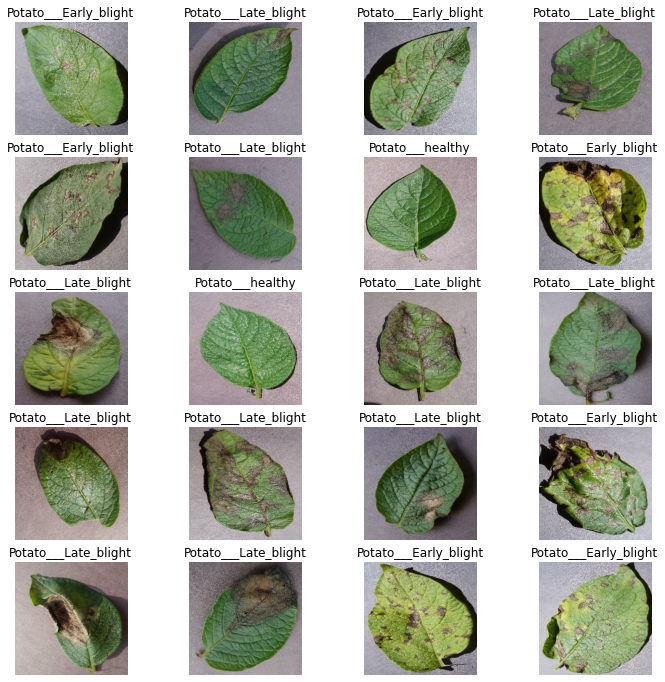

In [68]:
for image_batch,label_batch in data.take(1):
    plt.figure(figsize=(12,12))
    for i in range(20):
        ax = plt.subplot(5,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(data.class_names[label_batch[i]])
        

# creating a function to partition the dataset into train,test and validation, based on custom parameters.

In [69]:
def get_partitions(dataset,train_size,validation_size,test_size,shuffle,shuffle_size):
    if (train_size+validation_size+test_size==1.0):
        if shuffle:
            dataset=dataset.shuffle(shuffle_size,seed=12)
        train_ds = dataset.take(int(train_size*len(dataset)))
        whole_test_ds = dataset.skip(int(train_size*len(dataset)))
        val_ds = whole_test_ds.take(int(validation_size*len(dataset)))
        test_ds = whole_test_ds.skip(int(validation_size*len(dataset)))
        return train_ds,val_ds,test_ds
    else:
        print('Incorrect parameters,the sum of all sizes should be equal to 1')

In [70]:
train,val,test = get_partitions(data,0.8,0.1,0.1,True,10000)

In [71]:
train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test=test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val=val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# creating a data_augmentation , resizing and rescaling layers using sequential.

In [72]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [73]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [76]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=(32,256,256,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(3,activation='softmax'),
    
])
model.build(input_shape=(32,256,256,3))

In [77]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_6 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [78]:
model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [83]:
model.fit(train,epochs=10,batch_size=32,verbose=1,validation_data=val)

Epoch 1/10
54/54 [==============================] - 57s 1s/step - loss: 0.1871 - accuracy: 0.9225 - val_loss: 0.2608 - val_accuracy: 0.9115
Epoch 2/10
54/54 [==============================] - 58s 1s/step - loss: 0.1854 - accuracy: 0.9242 - val_loss: 0.1957 - val_accuracy: 0.9427
Epoch 3/10
54/54 [==============================] - 56s 1s/step - loss: 0.1639 - accuracy: 0.9340 - val_loss: 0.1856 - val_accuracy: 0.9271
Epoch 4/10
54/54 [==============================] - 56s 1s/step - loss: 0.1333 - accuracy: 0.9491 - val_loss: 0.2521 - val_accuracy: 0.8958
Epoch 5/10
54/54 [==============================] - 56s 1s/step - loss: 0.1125 - accuracy: 0.9578 - val_loss: 0.3077 - val_accuracy: 0.8906
Epoch 6/10
54/54 [==============================] - 56s 1s/step - loss: 0.1113 - accuracy: 0.9606 - val_loss: 0.2166 - val_accuracy: 0.9167
Epoch 7/10
54/54 [==============================] - 56s 1s/step - loss: 0.1019 - accuracy: 0.9612 - val_loss: 0.2149 - val_accuracy: 0.9271
Epoch 8/10
54/54 [==

In [100]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array,0)
    predictions = model.predict(img_array)
    predicted_class=data.class_names[np.argmax(predictions)]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

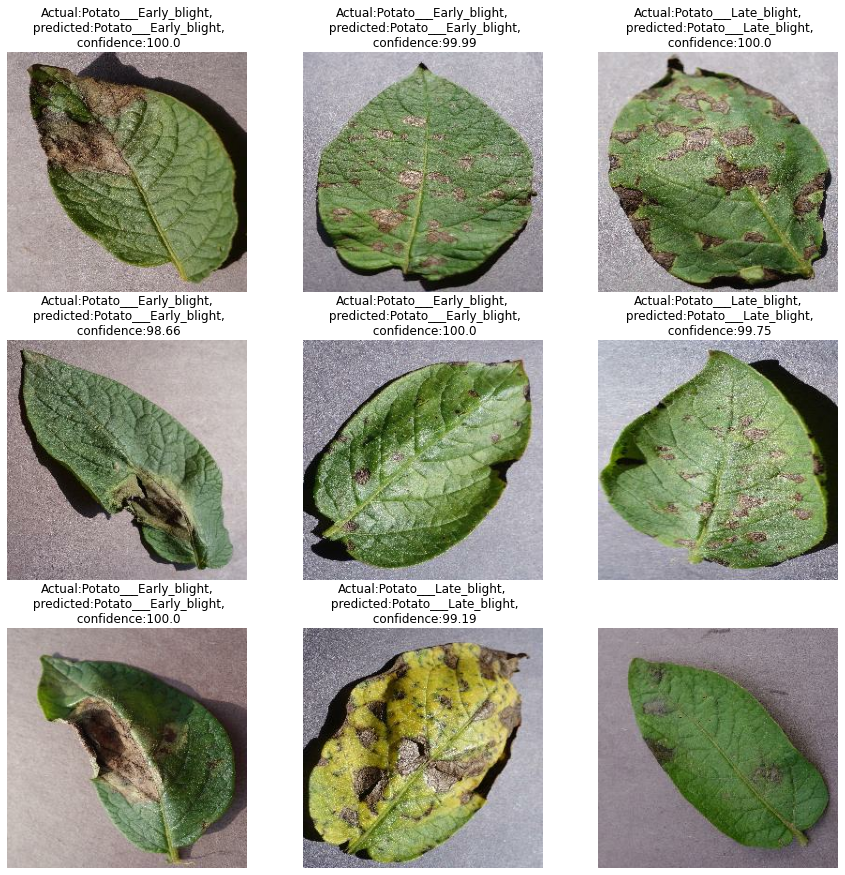

In [101]:
plt.figure(figsize=(15,15))
for images,labels in test.take(1):
    for i in range(9):
        predicted_class,confidence = predict(model,images[i])
        plt.title(f"Actual:{data.class_names[labels[i]]},\n predicted:{predicted_class},\n confidence:{confidence}")
        ax= plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis('off')